## Pytorch CNN with Custom Dataset

Reference 
- [Pytorch Document](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [GeeksForgeeks Article](https://www.geeksforgeeks.org/deep-learning/building-a-convolutional-neural-network-using-pytorch/)
- [Medium Article](https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc)


In [70]:
import torch
import torchvision
import torchvision.transforms as transforms 
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
from torchvision.io import decode_image
from torch.utils.data import DataLoader


device = ("cuda" if torch.cuda.is_available() else "cpu")


Create Utility Function

In [77]:
img_size = (480,480)

def imshow(img):
    img = img/2 + 0.5 # Unnormalization
    npimg = img.numpy() # Make it numpy
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()


cat_transformer = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomCrop((299,299)),
])

Loading the Dataset

In [79]:
train_df = pd.DataFrame(columns=['img_name','label'])
for idx,i in enumerate(os.listdir("data/cat-dataset/train/khawtang/")):
    train_df.loc[idx,'label'] = 0.0
    train_df.loc[idx,'img_name'] = "khawtang/"+i

for idx,i in enumerate(os.listdir("data/cat-dataset/train/khawniewping/")):
    train_df.loc[idx,'label'] = 1.0
    train_df.loc[idx,'img_name'] = "khawniewping/"+i

train_df.to_csv(r'cat_train_csv.csv',index=False,header=True)

Creating Custom Data Class

In [80]:
class CatDataset(Dataset):
    def __init__(self,annotations_file,img_dir,transform=None,target_transform=None):
        super().__init__()
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir  = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir,self.img_labels.iloc[idx,0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx,1]

        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image,label

Get the Dataset from the class

In [81]:
train_cat_data = CatDataset(annotations_file='cat_train_csv.csv',img_dir='data/cat-dataset/train',transform=cat_transformer)

In [82]:
train_data_loader = DataLoader(train_cat_data,batch_size=64,shuffle=True)

Iterate through the Data Loader

Feature Batch Size : torch.Size([32, 3, 299, 299])
Label Batch Size :  torch.Size([32])


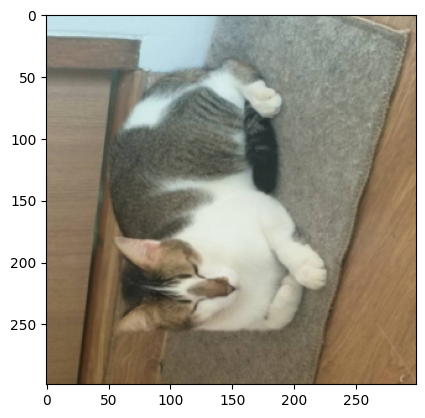

Label: 1.0


In [83]:
train_features,train_labels = next(iter(train_data_loader))
print(f'Feature Batch Size : {train_features.size()}')
print(f'Label Batch Size :  {train_labels.size()}')

# Show the first Image ?
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T,cmap='gray')
plt.show()
print(f'Label: {label}')

In [84]:
classes = ('khawtang', 'khawniewping')

### Model Defining
Defining the CNN Model which include the Conv Layer, Pooling Layer and Fully Connected Layer

In [85]:
# Defining the CNN Model extending the pytorch NN Model
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork,self).__init__()
        # Does not specify the input size for height and width; 
        # the input must be a tensor of shape (batch_size, 3, height, width), where the height and width can be any valid dimension.
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 6,kernel_size =5)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 6,out_channels=16,kernel_size=5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        ## First Step Value
        x = self.conv1(x)
        # Take the activation layer
        x = torch.relu(x)
        # Take the pooling layer
        x = self.pool(x)

        ## Second Step 
        # ConvNet
        x = self.conv2(x)
        # Activation
        x = torch.relu(x)
        # Pooling Layer
        x = self.pool(x)

        x = x.view(-1,16*5*5)

        # Taking into the fully-connected layer
        x = self.fc1(x)
        # Activation
        x = torch.relu(x)

        # Take the second FC Layer short hand
        x = torch.relu(self.fc2(x))

        # Take the final fc layer which activated to the class
        x = self.fc3(x)
        return x

net = MyNetwork() 

        

Visualize the model

In [86]:
writer = SummaryWriter('runs/basic_experiment')

Define the loss function and optimizer

In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

Define the loader

In [88]:
train_data_loader

Model Training Process

In [89]:
for epoch in range(2):   # loop over the dataset multiple times
    running_loss  = 0.0

    for i,data in enumerate(train_data_loader,0):
        # Loading the input i 
        print ('Iteration',i)
        inputs, labels = data
        print("Label",labels)
        print('--------')
        
        # Set the gradient to none
        optimizer.zero_grad()


        # Forward, Backward and Optimize
        # Take the input into model and Recieve the output 
        outputs = net(inputs)

        # Analysis of output using cross entrophy
        loss = criterion(outputs,labels)
        
        # Backward Propagation
        loss.backward()

        # Perform the optimizer 1 step for reduce the loss
        optimizer.step()

        # sum of each lose
        running_loss += loss.item()
        
        # Print Every 2000 Mini batchs
        if i % 2000 == 1999:
            # Find the average loss
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))

            # Clear the loss
            running_loss = 0.0

print('Finish Training')



Iteration 0
Label tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       dtype=torch.float64)
--------


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# write to tensorboard
writer.add_image('basic_experiment', img_grid)

Save the trained Model

In [ ]:
PATH = './cifar_net.pth'
# Save from the current stage of torch network
torch.save(net.state_dict(),PATH)

Test the model

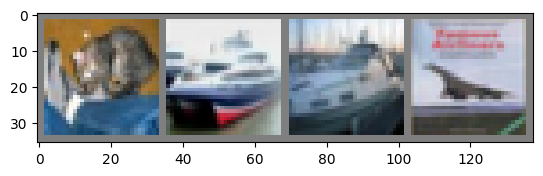

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(test_loader)
# Next Function return next iterm from iteration
images,labels = next(dataiter)

# Print Images 
fig,ax = plt.subplots(1,1)
imshow(torchvision.utils.make_grid(images))

# Display the ground truth
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Trying to load
Trying to load from our pretrained model

In [ ]:
net = MyNetwork()
net.load_state_dict(torch.load(PATH,weights_only=True))

<All keys matched successfully>

Try to make them predict our images

In [ ]:
output = net(images)

In this example we has 10 classes of samples.
The model will have a different confidences for classify that image to be each class.

It will represent in the titled of **Energy**
For example, if this image possible to be cat more than dog and rat.
The energy to be cat will be higher than energy of to be dog, and rat.

using function `torch.max(outputs,1)` will return only the highest energy class.

Show the highest energy of first 5 test images

In [ ]:
_,predicted = torch.max(outputs,1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  truck bird  bird  cat  


Find the overall accuracy of network, by summation the error and find the average accuracy.

In [ ]:
correct = 0
total = 0

# We are not in training, we don't need to calculate gradient

with torch.no_grad():
    for data in test_loader:
        images,labels = data

        # Calculate the output or it can called predict the image
        outputs = net(images)

        # Find the class with the highest energy (it want to choose at the prediction result)
        _,predicted = torch.max(output,1)
        # Summarize the total number of predicted image
        total += labels.size(0)
        # Count correct when it prediced is as same as the label
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 9 %
